# Part 1: Researching the Difference Between AI and Human Generated Text Using Sentence Embedding

In this part of the blog, we will explore the differences between AI and human-generated text using sentence embedding alone.


In [44]:
# Data Handling and Processing
import pandas as pd
import numpy as np
import itertools

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text Analysis
import string
import re

first, we use the daigt-v3 data set. it has prompt generated text by vaiours ai, including New models: 'text-ada-001', 'text-babbage-001', 'text-curie-001', 'text-davinci-001', 'text-davinci-002', 'text-davinci-003'


In [45]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thedrcat/daigt-v3-train-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/yang/.cache/kagglehub/datasets/thedrcat/daigt-v3-train-dataset/versions/2


In [46]:
!ls /home/yang/.cache/kagglehub/datasets/thedrcat/daigt-v3-train-dataset

2.complete  versions


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [47]:
# DAIGT v2 train dataset
df = pd.read_csv("/home/yang/.cache/kagglehub/datasets/thedrcat/daigt-v3-train-dataset/versions/2/train_v3_drcat_02.csv")

In [130]:
df['source'].unique()

array(['persuade_corpus', 'mistral7binstruct_v2', 'llama_70b_v1',
       'chat_gpt_moth', 'darragh_claude_v7', 'darragh_claude_v6',
       'mistral7binstruct_v1', 'llama2_chat', 'falcon_180b_v1',
       'radek_500', 'NousResearch/Llama-2-7b-chat-hf',
       'mistralai/Mistral-7B-Instruct-v0.1', 'palm-text-bison1',
       'cohere-command', 'radekgpt4', 'train_essays', 'kingki19_palm',
       'Intel-neural-chat-7b-v3-1_LLMEssays_v1', 'Mistral7B_CME_v7',
       'llama_falcon_v3_llama_70b', 'llama_falcon_v3_falcon_180b',
       'nima_gpt4', 'text-ada-001', 'text-babbage-001', 'text-curie-001',
       'text-davinci-001', 'text-davinci-002', 'text-davinci-003'],
      dtype=object)

In [164]:

human_list = ['persuade_corpus', 'train_essays']
# Top tier models for text generation
ai_top_list = [
    'radekgpt4', 'nima_gpt4', 'text-davinci-003', 
    'darragh_claude_v7', 
    'llama_70b_v1', 'llama2_chat', 'falcon_180b_v1', 
    'mistral7binstruct_v2', 'mistralai/Mistral-7B-Instruct-v0.1']


In [74]:
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm
import importlib
import utils.tokenize
importlib.reload(utils.tokenize)
from utils.tokenize import embed_batch, embed_text
import importlib


In [75]:
result = embed_text(text)

In [78]:
batch_size = 16

In [93]:
import json
import numpy as np

def process_texts(texts, filename):
    def safe_embed_string(text_batch):
        try:
            return embed_batch(text_batch)
        except Exception as e:
            return [None] * len(text_batch)

    #results = []
    for i in tqdm(range(0, len(texts), batch_size), total=len(texts)//batch_size):
        batch = texts[i:i+batch_size]
        batch_results = safe_embed_string(batch)
        #results.extend(batch_results)
        for batch_result in batch_results:
            if batch_result is not None and isinstance(result['embedding'], np.ndarray):
                batch_result['embedding'] = batch_result['embedding'].tolist()
        with open(filename, 'a') as f:
            json.dump(batch_results, f)
            f.write('\n')
    
    #return results

In [95]:
process_texts(df['text'], 'embedding_all-MiniLM-L6-v2.json')

  0%|          | 0/4079 [00:00<?, ?it/s]

read all json files created, and construct dataframe from it. 

In [103]:
# Initialize an empty list to store the JSON objects
json_objects = []

# Open the JSON file and read each line
with open('./embedding_all-MiniLM-L6-v2.json', 'r') as file:
    for line in file:
        # Each line contains multiple JSON objects
        objects = json.loads(line)
        json_objects.extend(objects)

# Convert the list of JSON objects into a DataFrame
embedding_df = pd.DataFrame(json_objects)

# Display the DataFrame
print(embedding_df.head())

                                           embedding  \
0  [0.000498077308293432, 0.016263578087091446, 0...   
1  [-0.07254071533679962, 0.08159153908491135, 0....   
2  [0.013036476448178291, 0.07388433068990707, 0....   
3  [0.015334401279687881, 0.017214564606547356, 0...   
4  [-0.05011904984712601, 0.021999651566147804, 0...   

                                       text_embedded  text_embedding_tc  
0  phonesmodern humans today are always on their ...                448  
1  this essay will explain if drivers should or s...                433  
2  driving while the use of cellular devicestoday...                199  
3  phones & drivingdrivers should not be able to ...                245  
4  cell phone operation while drivingthe ability ...                367  


In [104]:
embedding_df.to_csv('embedding_all-MiniLM-L6-v2.csv', index=False)

In [ ]:
embedding_df.to_pickle('embedding_all-MiniLM-L6-v2.pkl')

## clustering examination: pca on all data points all at once. 
perform pca on all data 

In [ ]:
from sklearn.decomposition import PCA
import joblib

# Extract the embeddings
embeddings = np.array(embedding_df['embedding'].tolist())

# Perform PCA
pca = PCA(n_components=30, random_state=42)
reduced_embeddings = pca.fit_transform(embeddings)

# Add the reduced embeddings back to the dataframe
embedding_df['reduced_embedding'] = list(reduced_embeddings)


# Save the PCA model to a file
joblib.dump(pca, 'pca_all_data.pkl')


In [ ]:
from sklearn.manifold import TSNE

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=50, random_state=42)
tsne_results = tsne.fit_transform(reduced_embeddings)

# Add the t-SNE results to the dataframe
embedding_df['tsne_p50_1'] = tsne_results[:, 0]
embedding_df['tsne_p50_2'] = tsne_results[:, 1]

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(reduced_embeddings)

# Add the t-SNE results to the dataframe
embedding_df['tsne_p30_1'] = tsne_results[:, 0]
embedding_df['tsne_p30_2'] = tsne_results[:, 1]

embedding_df.to_pickle('embedding_all-MiniLM-L6-v2_plots.pkl')

same procedure, but only use persuade data set for pca training. 

In [ ]:

# Extract the embeddings
embeddings = np.array(embedding_df['embedding'].tolist())

# Fit PCA on part of the dataframe where source == 'persuade_corpus'
persuade_corpus_embeddings = np.array(embedding_df[df['source'] == 'persuade_corpus']['embedding'].tolist())
pca = PCA(n_components=30, random_state=42)
pca.fit(persuade_corpus_embeddings)

# Transform the entire dataframe
reduced_embeddings = pca.transform(embeddings)

# Add the reduced embeddings back to the dataframe
embedding_df['reduced_embedding_human'] = list(reduced_embeddings)

# Save the PCA model to a file
joblib.dump(pca, 'pca_human_data.pkl')


['pca_human_data.pkl']

In [141]:


# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=50, random_state=42)
tsne_results = tsne.fit_transform(reduced_embeddings)

# Add the t-SNE results to the dataframe
embedding_df['tsne_human_p50_1'] = tsne_results[:, 0]
embedding_df['tsne_human_p50_2'] = tsne_results[:, 1]

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(reduced_embeddings)

# Add the t-SNE results to the dataframe
embedding_df['tsne_human_p30_1'] = tsne_results[:, 0]
embedding_df['tsne_human_p30_2'] = tsne_results[:, 1]

embedding_df.to_pickle('embedding_all-MiniLM-L6-v2_plots.pkl')

combine dataframes and visualize tsne results

In [155]:
df = pd.concat([df, embedding_df[['text_embedded', 'reduced_embedding', 'reduced_embedding_human', 'tsne_p50_1', 'tsne_p50_2', 'tsne_p30_1', 'tsne_p30_2', 'tsne_human_p50_1', 'tsne_human_p50_2', 'tsne_human_p30_1', 'tsne_human_p30_2']]], axis=1)
df.to_pickle('train_v3_drcat_02_with_embeddings.pickle')

## visualize the TSNE result

In [ ]:
def plot_tsne(df, hue='prompt_name', x_col='tsne_human_p30_1', y_col='tsne_human_p30_2', title='t-SNE Embedding of Combined DataFrame', legend_pos='best', hue_order=None, palette=None, hue_min=None, hue_max=None):
    fig, ax = plt.subplots(figsize=(12, 8))
    if palette is None: 
        palette = sns.color_palette("Set1") + sns.color_palette("Set2")
    
    if pd.api.types.is_numeric_dtype(df[hue]):
        norm = plt.Normalize(vmin=hue_min if hue_min is not None else df[hue].min(), vmax=hue_max if hue_max is not None else df[hue].max())
        sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
        sm.set_array([])
        sns.scatterplot(data=df, x=x_col, y=y_col, hue=hue, palette=palette, hue_norm=norm, alpha=0.7, s=3, ax=ax)
        cbar = fig.colorbar(sm, ax=ax)
    else:
        sns.scatterplot(data=df, x=x_col, y=y_col, hue=hue, alpha=0.7, s=3, palette=palette, hue_order=hue_order, ax=ax)
    
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('t-SNE Dimension 1', fontsize=15)
    ax.set_ylabel('t-SNE Dimension 2', fontsize=15)
    ax.legend(title=hue, markerscale=6, loc=legend_pos)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()


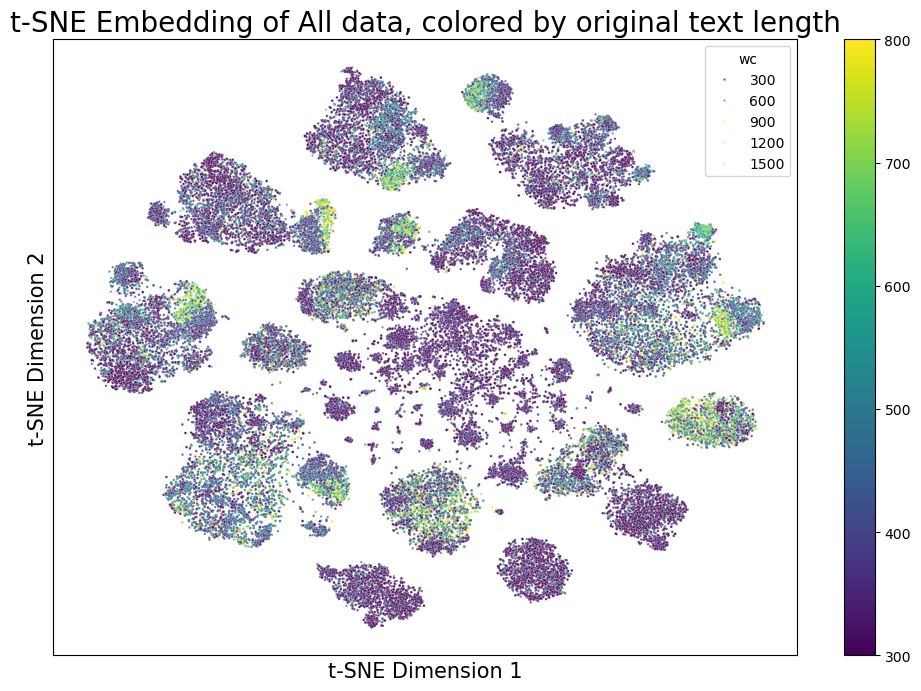

In [256]:
plot_tsne(df, hue='wc', title='t-SNE Embedding of All data, colored by original text length', palette='viridis', hue_min=300, hue_max = 800)

In [248]:
label_list = sorted(df['label'].unique())
model_list = sorted(df['model'].unique())
prompt_list = sorted(df['prompt_name'].unique())

/tmp/ipykernel_1808/3430741650.py:13: UserWarning: The palette list has more values (17) than needed (15), which may not be intended.
  sns.scatterplot(data=df, x=x_col, y=y_col, hue=hue, alpha=0.7, s=3, palette=palette, hue_order=hue_order)


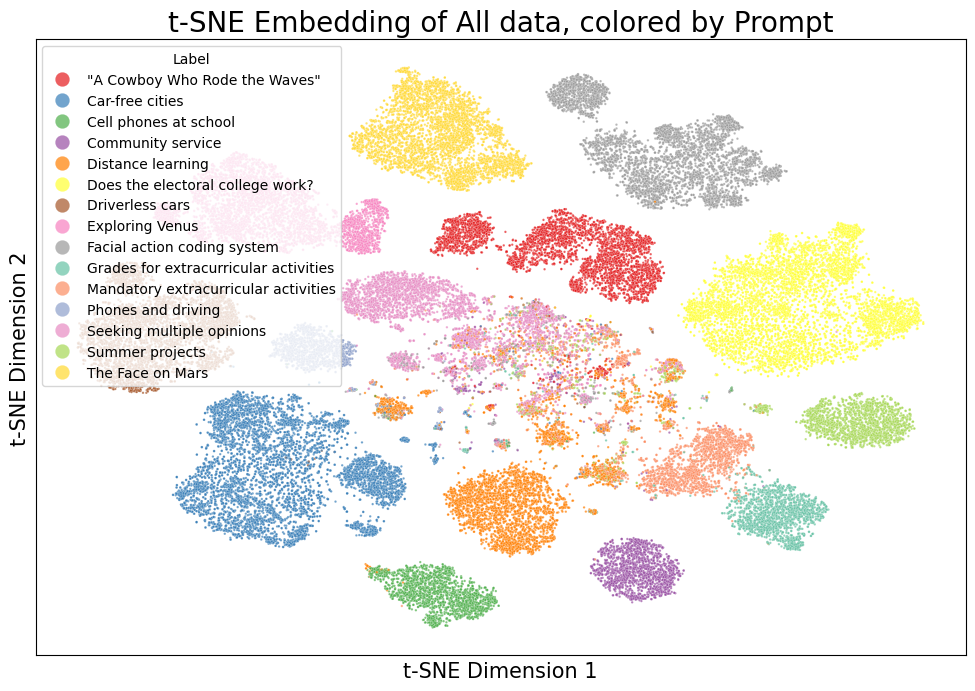

In [249]:
plot_tsne(df, hue='prompt_name', title='t-SNE Embedding of All data, colored by Prompt', hue_order=prompt_list)

/tmp/ipykernel_1808/3430741650.py:13: UserWarning: The palette list has more values (17) than needed (12), which may not be intended.
  sns.scatterplot(data=df, x=x_col, y=y_col, hue=hue, alpha=0.7, s=3, palette=palette, hue_order=hue_order)


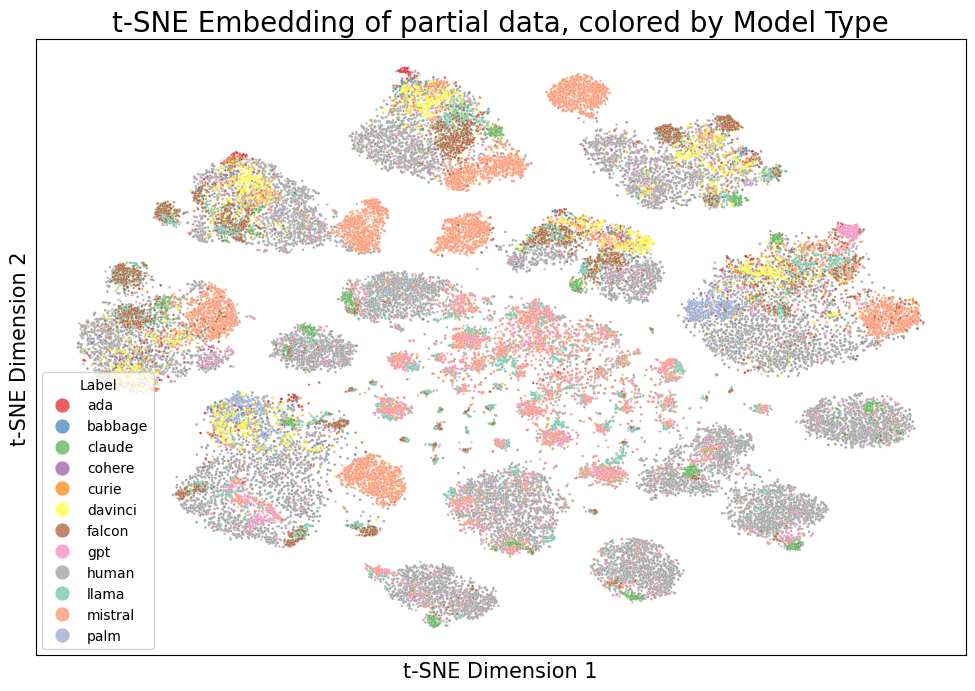

In [250]:
plot_tsne(df, hue='model', title='t-SNE Embedding of partial data, colored by Model Type', hue_order=model_list)

/tmp/ipykernel_1808/137063598.py:4: UserWarning: The palette list has more values (17) than needed (11), which may not be intended.
  sns.scatterplot(data=df, x=x_col, y=y_col, hue=hue, alpha=0.7, s=3, palette=palette, hue_order=hue_order)


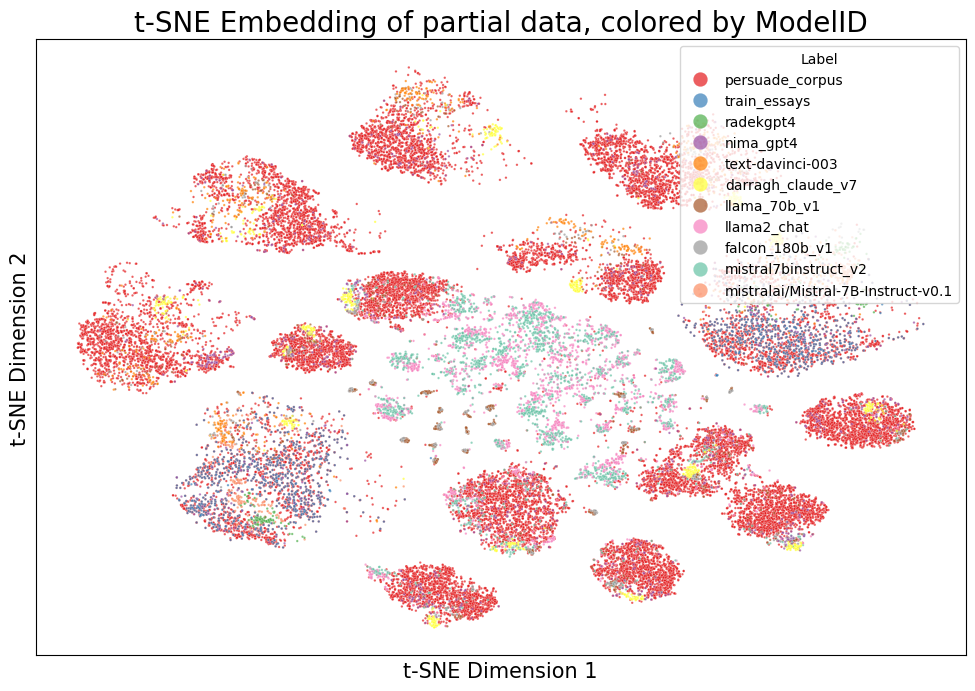

In [229]:
plot_source_list = human_list + ai_top_list
datadf = df[df['source'].isin(plot_source_list)]

plot_tsne(datadf, hue='source', title='t-SNE Embedding of partial data, colored by ModelID', hue_order=plot_source_list)

/tmp/ipykernel_1808/2944062919.py:4: UserWarning: The palette list has more values (17) than needed (2), which may not be intended.
  sns.scatterplot(data=df, x=x_col, y=y_col, hue=hue, alpha=0.7, s=3, palette=palette, hue_order=hue_order)


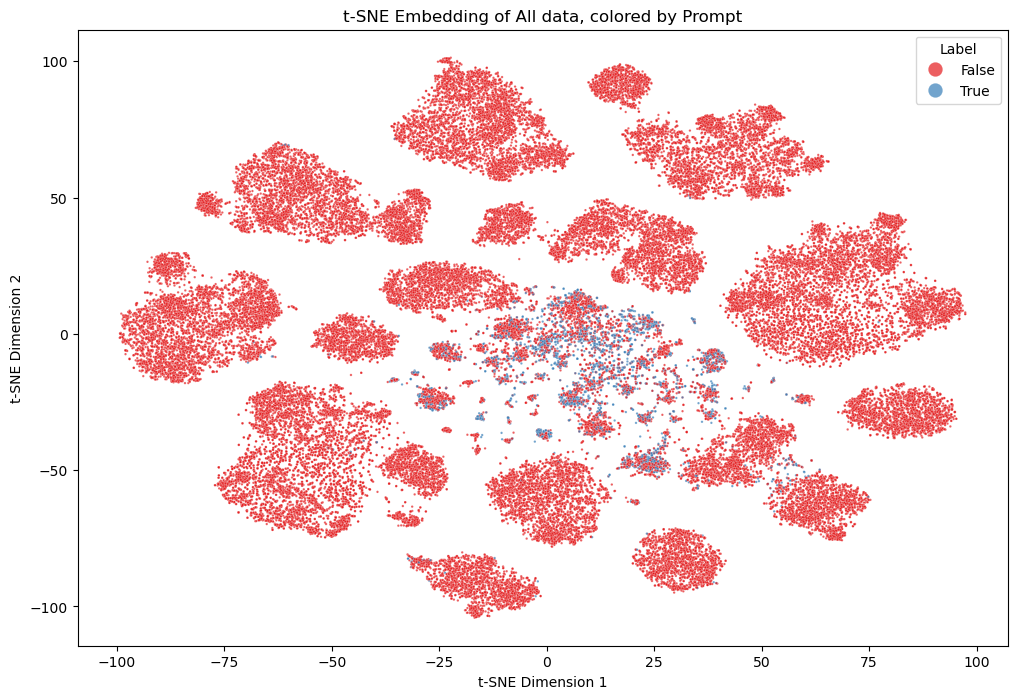

In [232]:
plot_tsne(df, hue='hard_to_classify', title='t-SNE Embedding of All data, colored by Prompt')

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score


# Extract features and target
X = np.array(df['reduced_embedding'].tolist())
y = df['prompt_name']

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Initialize classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and get predictions for each fold
predictions = cross_val_predict(classifier, X, y_encoded, cv=cv)

# Calculate accuracy score
scores = accuracy_score(y_encoded, predictions)

# Identify hard-to-classify data points (incorrect predictions)
accuracies = (predictions == y_encoded)
hard_to_classify = df[~accuracies]


# Print the cross-validation scores
print("Cross-validated scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validated scores: [0.95043665 0.94852153 0.94836436 0.94759825 0.94997319]
Mean accuracy: 0.9489787947878077


In [173]:
df['hard_to_classify'] = (predictions != y_encoded)

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

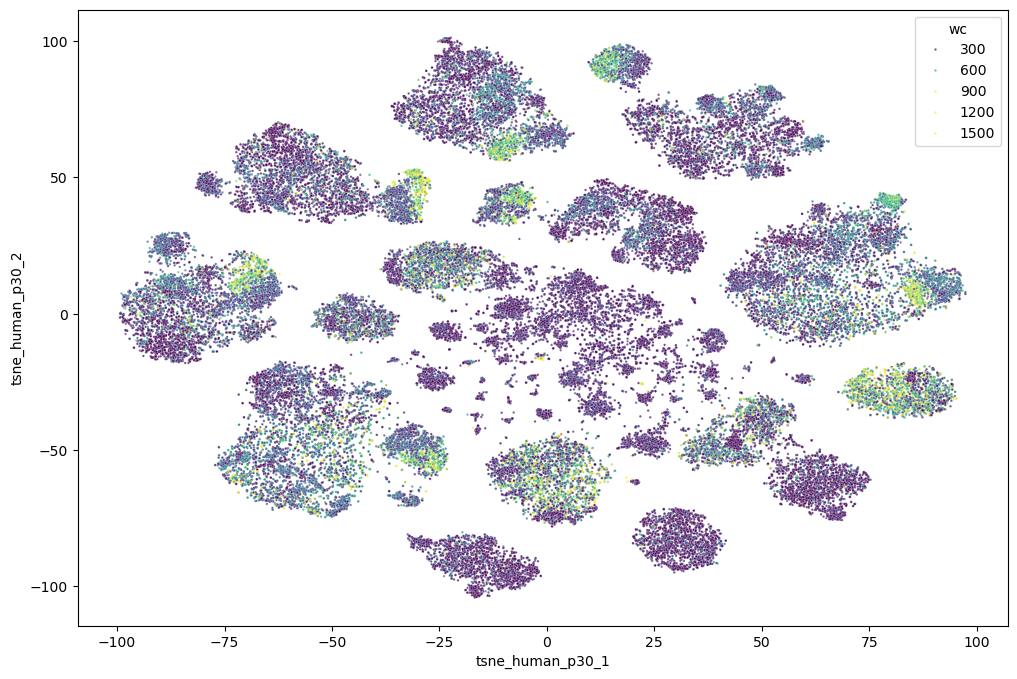

# focus on a few topic which there are lots of inputs

In [188]:
count_df = df.groupby(['prompt_name', 'source']).size().reset_index(name='counts')
count_df =  count_df.pivot_table(index='prompt_name', columns='source', values='counts', fill_value=0)
count_df = count_df.astype(int)


eventual pick of topics: 
[ 'Does the electoral college work?', 'Community service', 'Grades for extracurricular activities']
pick of "core" models: 


In [190]:
count_df[ai_top_list + ['persuade_corpus']]

source                                 radekgpt4  nima_gpt4  text-davinci-003  \
prompt_name                                                                     
"A Cowboy Who Rode the Waves"                  0         56               100   
Car-free cities                              100         80               100   
Cell phones at school                          0         64                 0   
Community service                              0         60                 0   
Distance learning                              0         88                 0   
Does the electoral college work?             100         84               100   
Driverless cars                                0         76               100   
Exploring Venus                                0         72               100   
Facial action coding system                    0         88               100   
Grades for extracurricular activities          0         64                 0   
Mandatory extracurricular activities           0         68                 0   
Phones and driving                             0         48                 0   
Seeking multiple opinions                      0         60                 0   
Summer projects                                0         68                 0   
The Face on Mars                               0         64               100   

source                                 darragh_claude_v7  llama_70b_v1  \
prompt_name                                                              
"A Cowboy Who Rode the Waves"                         73            54   
Car-free cities                                       49           188   
Cell phones at school                                 64            42   
Community service                                     53            40   
Distance learning                                     66           216   
Does the electoral college work?                      74            31   
Driverless cars                                       69            48   
Exploring Venus                                       64            31   
Facial action coding system                           70           111   
Grades for extracurricular activities                 64            95   
Mandatory extracurricular activities                  78            50   
Phones and driving                                    69           122   
Seeking multiple opinions                             77            56   
Summer projects                                       60            52   
The Face on Mars                                      70            36   

source                                 llama2_chat  falcon_180b_v1  \
prompt_name                                                          
"A Cowboy Who Rode the Waves"                   66              44   
Car-free cities                                 10             155   
Cell phones at school                           81              40   
Community service                              109              29   
Distance learning                              515             218   
Does the electoral college work?                 2              24   
Driverless cars                                 13              26   
Exploring Venus                                  2              33   
Facial action coding system                    182              99   
Grades for extracurricular activities           87              73   
Mandatory extracurricular activities           345              37   
Phones and driving                              14             108   
Seeking multiple opinions                      788              66   
Summer projects                                202              62   
The Face on Mars                                 2              29   

source                                 mistral7binstruct_v2  \
prompt_name                                                   
"A Cowboy Who Rode the Waves"                 

show word count distribution of a few topics

In [191]:
df['prompt_name'].unique()

array(['Phones and driving', 'Car-free cities', 'Summer projects',
       '"A Cowboy Who Rode the Waves"',
       'Mandatory extracurricular activities', 'Exploring Venus',
       'Facial action coding system', 'The Face on Mars',
       'Community service', 'Grades for extracurricular activities',
       'Driverless cars', 'Does the electoral college work?',
       'Cell phones at school', 'Distance learning',
       'Seeking multiple opinions'], dtype=object)

In [197]:
ai_top_list

['radekgpt4',
 'nima_gpt4',
 'text-davinci-003',
 'darragh_claude_v7',
 'llama_70b_v1',
 'llama2_chat',
 'falcon_180b_v1',
 'mistral7binstruct_v2',
 'mistralai/Mistral-7B-Instruct-v0.1']

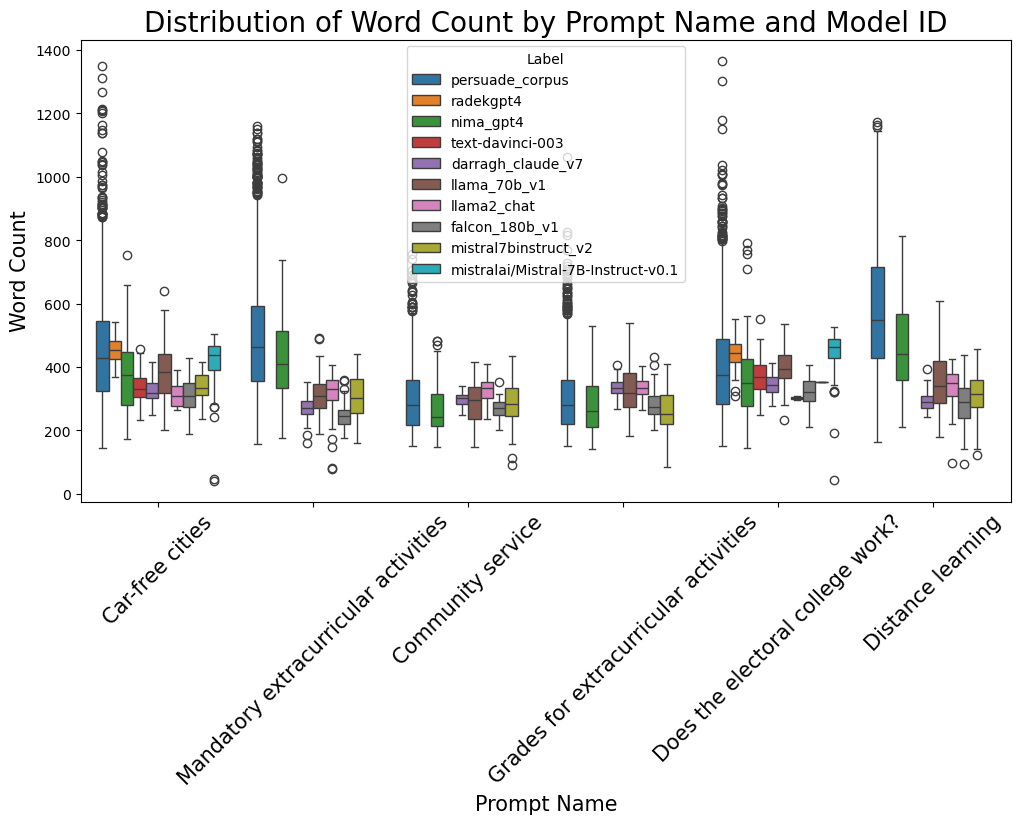

In [ ]:
df['wc'] = df['text'].apply(lambda x: len(x.split()))
subdf = df[df['prompt_name'].isin(['Distance learning', 'Car-free cities', 'Mandatory extracurricular activities', 'Does the electoral college work?', 'Community service', 'Grades for extracurricular activities']) \
           & df['source'].isin(ai_top_list + ['persuade_corpus'])]
plt.figure(figsize=(12, 6))
sns.boxplot(x='prompt_name', y='wc', hue='source', data=subdf, hue_order = ['persuade_corpus'] + ai_top_list)
plt.xticks(rotation=90)
p fontsize = 15lt.title('Distribution of Word Count by Prompt Name and Model ID', fontsize=20)
plt.xlabel('Prompt Name', fontsize=15)
plt.ylabel('Word Count', fontsize=15)
plt.legend(title='Label')
plt.show()

choose prompts which results in similar output length. thus, the prompts are chosen to be: 
[ 'Does the electoral college work?', 'Community service', 'Grades for extracurricular activities']

In [123]:
subdf = pd.concat([df[selection], embedding_df[selection]], axis=1)
subdf.to_csv('subdf_all-MiniLM-L6-v2.csv', index=False)
subdf.to_pickle('subdf_all-MiniLM-L6-v2.pkl')

In [122]:
df.shape, embedding_df.shape, df[selection].shape, embedding_df[selection].shape, subdf.shape

((65267, 6), (65267, 3), (46476, 6), (46476, 3), (46476, 9))